目前的量化策略主要可以分为两大类：均值回归和趋势跟随。在使用均值回归类策略的时候，要求时间序列是平稳的。这里的平稳可以理解为价格的均值是与时间无关的，即不同时点的分布中，变量都是围绕同一个值波动的。

### 1. ADF检验
判断数据是否平稳常用的统计检验方法就是ADF检验，也叫做单位根检验。单位根检验是指检验序列中是否存在单位根，存在单位根就是非平稳时间序列，否则就是平稳的。原因涉及数据推论，不展开，[可以参考这里](https://zhuanlan.zhihu.com/p/652229829).
那怎么进行ADF检验呢？可以将这两个假设作为初始假设：

- 零假设(H0)
    - 时间序列是不平稳的(存在单位根)
- 备择假设(H1)
    - 时间序列是平稳的(不存在单位根)
为了对进一步理解上述过程，选取数据进行测试。

In [1]:
from __future__ import print_function
# Import the Time Series library
import statsmodels.tsa.stattools as ts
# Import Datetime and the Pandas DataReader
from datetime import datetime 
import pandas_datareader.data as web
from matplotlib import pyplot as plt
import numpy as np
import mplfinance as mpf

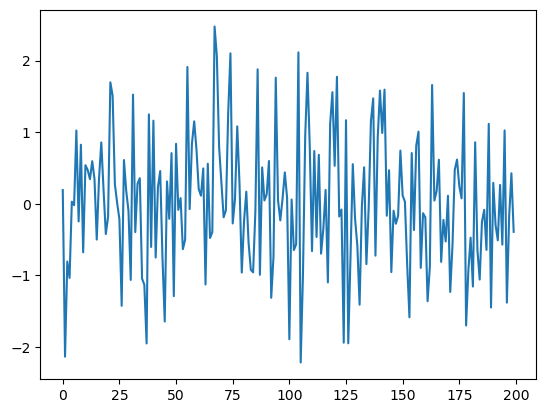

In [2]:
# 1.1 首先使用python生成真正的平稳序列进行结果说明，使用numpy 生成
y = np.random.standard_normal(size=200)
# 画图展示更直观
plt.plot(y)
plt.show()

In [3]:
# Output the results of the Augmented Dickey-Fuller test a lag order value of 1
ts.adfuller(y, 1)

(-14.169534987878377,
 2.0145744418637853e-26,
 0,
 199,
 {'1%': -3.4636447617687436,
  '5%': -2.8761761179270766,
  '10%': -2.57457158581854},
 530.933646616362)

结果中，第一个是adt检验的结果，简称为T值，表示t统计量；
第二个简称为p值，表示t统计量对应的概率值，p值越小，说明越可能是平稳的时间序列；
第三个表示延迟值；
第四个表示测试的次数；
第五个配合第一个一起看，是在99%，95%，90%置信区间下的临界的ADF检验的值
-15.334491495290056比3个检验值1%，5%，10%都要小，所以拒绝原假设H0，即数据是平稳的，和预期一致。

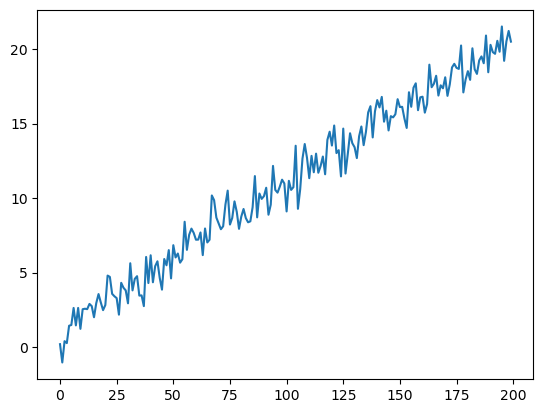

In [4]:
# 1.2 下面对y值进行修改，使其成为假的平稳序列
for i in range(1, len(y)):
    y[i] = 1 + 0.1*i + y[i]
# 画图展示更直观
plt.plot(y)
plt.show()

In [5]:
# Output the results of the Augmented Dickey-Fuller test a lag order value of 1
ts.adfuller(y, 1)

(-1.2435971772358922,
 0.6545659352168965,
 1,
 198,
 {'1%': -3.4638151713286316,
  '5%': -2.876250632135043,
  '10%': -2.574611347821651},
 611.4540006625357)

-0.8572801093306679比3个检验值1%，5%，10%都要大，所以无法拒绝原假设H0，即数据是非平稳的

In [7]:
# 1.3 最后使用 螺纹钢的收盘价进行检验
import akshare as ak
rb0_df = ak.futures_main_sina(symbol="RB0", start_date="20230101", end_date="20230901")
print(rb0_df[:3])

           日期   开盘价   最高价   最低价   收盘价      成交量      持仓量  动态结算价
0  2023-01-03  4100  4100  4016  4063  1245821  1882723   4044
1  2023-01-04  4061  4084  4010  4027  1383006  1874643   4045
2  2023-01-05  4015  4024  3970  4017  1522301  1825776   4001


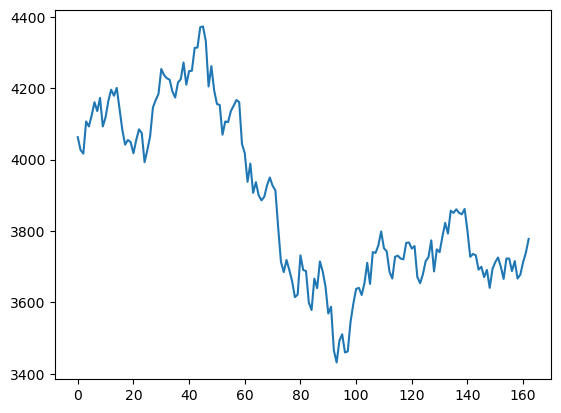

In [8]:
plt.plot(rb0_df["收盘价"])

In [9]:
ts.adfuller(rb0_df["收盘价"], 1)

(-1.3313386978453678,
 0.6147156917650225,
 0,
 162,
 {'1%': -3.471374345647024,
  '5%': -2.8795521079291966,
  '10%': -2.5763733302850174},
 1694.0819641398427)

-1.3313386978453678比3个检验值1%，5%，10%都要大，所以无法拒绝原假设H0，即收盘价数据是非平稳的，无法使用均值回归策略

### 2. 赫斯特指数
下面介绍赫斯特指数(Hurst Exponent)，是用来衡量时间序列是否有长期记忆的一个指标,也即在一定程度上可以判断当前价格是否和历史存在某种关系。
Hurst 指数 > 0.5，说明记忆强，未来的增量和过去的增量相关，继续保持现有趋势的可能性强(trending)；
Hurst 指数 < 0.5，很有可能是记忆的转弱，趋势结束和反转的开始(mean reversion)。
Hurst指数数值越靠近0.5说明随机性越强，无法判定走向(Random Walk)。


In [10]:
# 2.1 首先是赫斯特指数的实现
from numpy import cumsum, log, polyfit, sqrt, std, subtract 
from numpy.random import randn
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts""" 
    # Create the range of lag values
    lags = range(2, 100)
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags] 
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

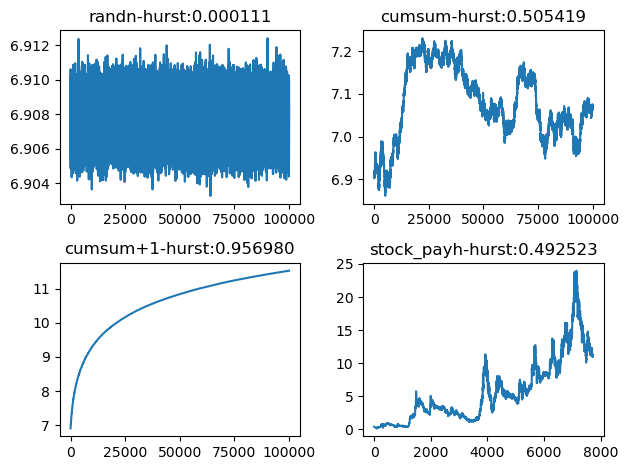

In [20]:
# 2.2 使用2个示例数据进行计算验证
fig, ax = plt.subplots(2, 2)
## 2.2.1 真平稳序列
y1 = log(randn(100000) + 1000)
ax[0,0].set_title('randn-hurst:' +str(hurst(y1))[0:8])
ax[0,0].plot(y1)

## 2.2.2 假的平稳序列
y2 = log(cumsum(randn(100000))+1000)
ax[0,1].set_title('cumsum-hurst:' +str(hurst(y2))[0:8])
ax[0,1].plot(y2)

## 2.2.3 趋势
y3 = log(cumsum(randn(100000)+1)+1000)
ax[1,0].set_title('cumsum+1-hurst:' +str(hurst(y3))[0:8])
ax[1,0].plot(y3)


## 2.2.4 stock
stock_payh_df = ak.stock_zh_a_daily(symbol="sz000001", adjust="qfq")
ax[1,1].set_title('stock_payh-hurst:' +str(hurst(stock_payh_df['close'].to_numpy()))[0:8])
ax[1,1].plot(stock_payh_df['close'])

fig.tight_layout()
plt.show()

randn-hurst数值接近于0，判定为均值回归；cumsum+1-hurst数值接近于1，判定为趋势；两外2个数值非常接近0.5，判定为随机事件。

### 3. 协整
找到均值回归的股票是比较难的，单个股票的走势更趋向于随机漫步(塔勒布的相关书籍)。那有没有办法在股票之间找到一种关系，来使用均值回归呢？比较简单的一种方法就是构建组合，形成配对交易。如果2只股票之间存在某种线性关系，则可以用来构建配对交易。

In [96]:
import pandas as pd
import matplotlib.dates as mdates

### 3.1 画价格图
def plot_price_series(df, ts1, ts2):
    fig, ax = plt.subplots()
    ax.plot(df.index, df[ts1], label=ts1)
    ax.plot(df.index, df[ts2], label=ts2) 
    #ax.grid(True)
    #fig.autofmt_xdate()
    gap = 10
    #plt.xticks(ticks =  np.arange(0,len(df)), labels = df.date.dt.strftime('%Y-%m-%d').to_numpy())
    xlabel_name = df.date.dt.strftime('%Y-%m-%d').to_numpy()[::gap]
    plt.xticks(ticks =  np.arange(0,len(df),gap), labels = xlabel_name)
    plt.xlabel('Date')
    plt.xticks(rotation=90, size=8)
    plt.ylabel('Price')
    plt.title('%s and %s Daily Prices' % (ts1, ts2))
    plt.legend()
    plt.show()
    
### 3.2 画散点图
def plot_scatter_series(df, ts1, ts2):
    plt.xlabel('%s Price ($)' % ts1)
    plt.ylabel('%s Price ($)' % ts2)
    plt.title('%s and %s Price Scatterplot' % (ts1, ts2))
    plt.scatter(df[ts1], df[ts2])
    plt.show()
    
def plot_residuals(df):
    months = mdates.MonthLocator() # every month 
    fig, ax = plt.subplots()
    ax.plot(df.index, df["res"], label="Residuals")
    gap = 10
    xlabel_name = df.date.dt.strftime('%Y-%m-%d').to_numpy()[::gap]
    plt.xticks(ticks =  np.arange(0,len(df),gap), labels = xlabel_name)
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.xticks(rotation=90, size=8)
    plt.title('Residual Plot')
    plt.legend()
    plt.plot(df["res"])
    plt.show()

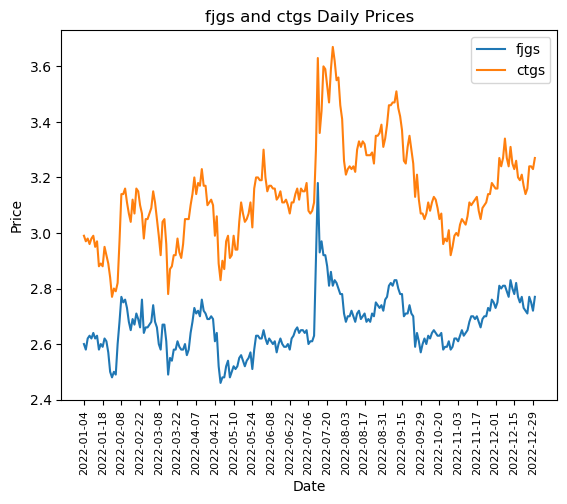

In [106]:
# 福建高速
fjgs =  ak.stock_zh_a_daily(symbol="sh600033", start_date="20220101", end_date="20230101",adjust="qfq")
#print(fjgs[:-3])
#print(fjgs.index)
# 楚天高速
ctgs = ak.stock_zh_a_daily(symbol="sh600035",  start_date="20220101", end_date="20230101",adjust="qfq")
df = pd.DataFrame(index=fjgs.index)
# 使用np.log 取对数的方式对数据进行归一化
df["date"] = fjgs["date"]
df["fjgs"] = (fjgs["close"])
df["ctgs"] = (ctgs["close"])
print()
#print(df)
# Plot the two time series
plot_price_series(df, "fjgs", "ctgs")


1.1769674690078928
                                 OLS Regression Results                                
Dep. Variable:                   ctgs   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          2.482e+05
Date:                Fri, 15 Dec 2023   Prob (F-statistic):                        0.00
Time:                        12:29:52   Log-Likelihood:                          218.82
No. Observations:                 242   AIC:                                     -435.6
Df Residuals:                     241   BIC:                                     -432.2
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------

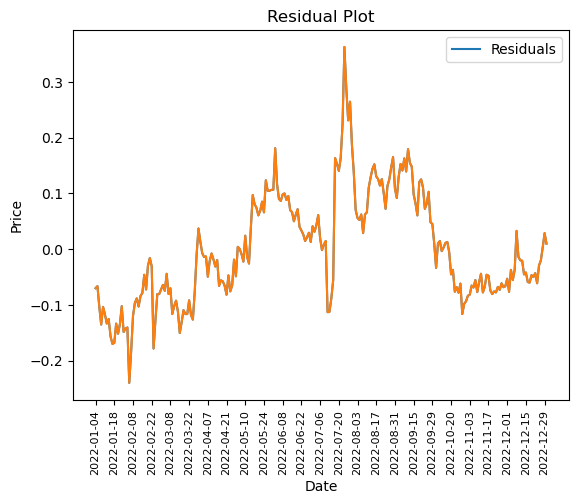

(-2.8725021914805806, 0.04864033297048336, 0, 241, {'1%': -3.4577787098622674, '5%': -2.873608704758507, '10%': -2.573201765981991}, -868.7248189359461)


In [107]:
import statsmodels.api as sm
model = sm.OLS(df["ctgs"], df["fjgs"])
res= model.fit()
print(res.params[0])
print(res.summary())
df["res"] = df["ctgs"] - res.params[0] *df["fjgs"]
#print(df["res"])
plot_residuals(df)
cadf = ts.adfuller(df["res"])
print(cadf)